In [67]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from flask import Flask, jsonify


In [49]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [50]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [51]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [52]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [53]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns: 
    print(column["name"], column["type"])
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [79]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data = engine.execute("select * from measurement")
# for record in data:
#     print(record)


In [55]:
conn = engine.connect()
data2 = pd.read_sql("select * from measurement", conn)
data2.head()


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [56]:
last = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
for last in last:
    print(last)
    

2017-08-23


In [57]:
last = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date, = last
year,month,day = last_date.split('-')
query_date = dt.date(int(year),int(month),int(day)) - dt.timedelta(days=365)
print(query_date)


2016-08-23


In [85]:
prcp = pd.DataFrame(session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=query_date).all())
prcp = prcp.set_index('date')
prcp.head()


,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


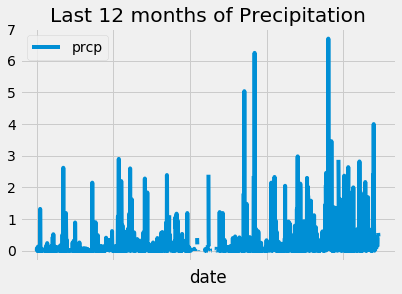

In [86]:
prcp.plot()
plt.title('Last 12 months of Precipitation')
plt.show()


In [60]:
prcp.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [61]:
stations_count = session.query(Measurement.station).group_by(Measurement.station).count()
print(f'There are {stations_count} weather observation stations.')


There are 9 weather observation stations.


In [62]:
station_observ = pd.DataFrame(session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all(),columns=['Station','Number of Measurements'])
station_observ



,Station,Number of Measurements
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [63]:
most_observ = station_observ.iloc[0,0]
print(f'{station_most_observations} has the most observations with {station_observations.iloc[0,1]} measurements.')


USC00519281 has the most observations with 2772 measurements.


In [64]:
last_year_temp = pd.DataFrame(session.query(Measurement.date,Measurement.station,Measurement.tobs)\
                              .filter(Measurement.date>query_date).filter(Measurement.station==station_most_observations).all())
last_year_temp = last_year_temp.set_index('date')
last_year_temp.head()


,station,tobs
date,,
2016-08-24,USC00519281,77.0
2016-08-25,USC00519281,80.0
2016-08-26,USC00519281,80.0
2016-08-27,USC00519281,75.0
2016-08-28,USC00519281,73.0


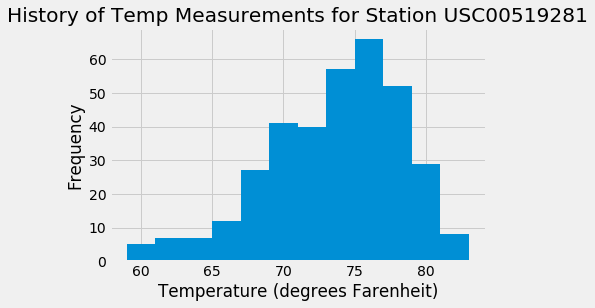

In [65]:
last_year_temp.hist(column='tobs',bins=12)
plt.xlabel('Temperature (degrees Farenheit)')
plt.ylabel('Frequency')
plt.title(f'History of Temp Measurements for Station {station_most_observations}')
plt.show()